In [ ]:
#COMPARISON IN THE LATENT SPACE
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Diffusion model definition
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the dataset
data = pd.read_csv('/content/mammography_dataset.csv', header=None)

# Separate features and target
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Autoencoder parameters
input_dim = X_tensor.shape[1]
latent_dim = 3
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Training the autoencoder
num_epochs = 50
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    for i in range(0, X_tensor.size(0), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract latent space representation
model.eval()
with torch.no_grad():
    latent_space = model.encoder(X_tensor).numpy()

# Save latent space to CSV
latent_space_df = pd.DataFrame(latent_space)
latent_space_df['target'] = y.values
latent_space_df.to_csv('/content/latent_space.csv', index=False)

# Split into train and test in the latent space
train_data, test_data = train_test_split(latent_space_df, test_size=0.2, stratify=latent_space_df['target'], random_state=42)

# Separate features and target for train and test
X_train, y_train = train_data.iloc[:, :-1], train_data['target']
X_test, y_test = test_data.iloc[:, :-1], test_data['target']

# Augment minority class (class 1) in latent space using diffusion model
minority_data = X_train[y_train == 1].values
num_augment = len(minority_data)  # 100% augmentation

# Initialize diffusion model
diffusion_model = DiffusionModel(latent_dim)
diffusion_optimizer = Adam(diffusion_model.parameters(), lr=0.001)

# Train diffusion model
num_diffusion_epochs = 100
minority_tensor = torch.tensor(minority_data, dtype=torch.float32)
for epoch in range(num_diffusion_epochs):
    diffusion_optimizer.zero_grad()
    noise = torch.randn_like(minority_tensor) * 0.1
    noisy_data = minority_tensor + noise
    generated_data = diffusion_model(noisy_data)
    loss = nn.MSELoss()(generated_data, minority_tensor)
    loss.backward()
    diffusion_optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Diffusion Epoch [{epoch+1}/{num_diffusion_epochs}], Loss: {loss.item():.4f}")

# Generate augmented data
with torch.no_grad():
    augmented_minority = diffusion_model(minority_tensor + torch.randn_like(minority_tensor) * 0.1).numpy()

# Combine augmented data with original latent space training data
latent_train_augmented = np.vstack([X_train, augmented_minority])
y_train_augmented = np.hstack([y_train, np.ones(num_augment)])

# Train classifiers and compare recall
clf = RandomForestClassifier(random_state=42)

# Without augmentation
clf.fit(X_train, y_train)
y_pred_original = clf.predict(X_test)
print("Performance without augmentation:")
print(classification_report(y_test, y_pred_original))

# With augmentation
clf.fit(latent_train_augmented, y_train_augmented)
y_pred_augmented = clf.predict(X_test)
print("Performance with augmentation:")
print(classification_report(y_test, y_pred_augmented))


Epoch [10/50], Loss: 0.0003
Epoch [20/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0003
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0003
Diffusion Epoch [10/100], Loss: 0.0334
Diffusion Epoch [20/100], Loss: 0.0113
Diffusion Epoch [30/100], Loss: 0.0089
Diffusion Epoch [40/100], Loss: 0.0073
Diffusion Epoch [50/100], Loss: 0.0067
Diffusion Epoch [60/100], Loss: 0.0064
Diffusion Epoch [70/100], Loss: 0.0063
Diffusion Epoch [80/100], Loss: 0.0062
Diffusion Epoch [90/100], Loss: 0.0061
Diffusion Epoch [100/100], Loss: 0.0051
Performance without augmentation:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2185
           1       0.81      0.40      0.54        52

    accuracy                           0.98      2237
   macro avg       0.90      0.70      0.77      2237
weighted avg       0.98      0.98      0.98      2237

Performance with augmentation:
              precision    recall  f1-score   support

           0       0.9

In [ ]:
#COMPARISON IN THE ORIGINAL SPACE AFTER DECODING
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Diffusion model definition
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the dataset
data = pd.read_csv('/content/mammography_dataset.csv', header=None)

# Separate features and target
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test before autoencoding
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Autoencoder parameters
input_dim = X_train_tensor.shape[1]
latent_dim = 3
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Training the autoencoder
num_epochs = 50
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    for i in range(0, X_train_tensor.size(0), batch_size):
        batch = X_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract latent space representation
model.eval()
with torch.no_grad():
    latent_train = model.encoder(X_train_tensor).numpy()
    latent_test = model.encoder(X_test_tensor).numpy()

# Augment minority class (class 1) in latent space using diffusion model
minority_data = latent_train[y_train == 1]
num_augment = len(minority_data)  # 100% augmentation

# Initialize diffusion model
diffusion_model = DiffusionModel(latent_dim)
diffusion_optimizer = Adam(diffusion_model.parameters(), lr=0.001)

# Train diffusion model
num_diffusion_epochs = 100
minority_tensor = torch.tensor(minority_data, dtype=torch.float32)
for epoch in range(num_diffusion_epochs):
    diffusion_optimizer.zero_grad()
    noise = torch.randn_like(minority_tensor) * 0.1
    noisy_data = minority_tensor + noise
    generated_data = diffusion_model(noisy_data)
    loss = nn.MSELoss()(generated_data, minority_tensor)
    loss.backward()
    diffusion_optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Diffusion Epoch [{epoch+1}/{num_diffusion_epochs}], Loss: {loss.item():.4f}")

# Generate augmented data
with torch.no_grad():
    augmented_minority = diffusion_model(minority_tensor + torch.randn_like(minority_tensor) * 0.1).numpy()

# Combine augmented data with original latent space training data
latent_train_augmented = np.vstack([latent_train, augmented_minority])
y_train_augmented = np.hstack([y_train, np.ones(num_augment)])

# Decode augmented data back to original space
with torch.no_grad():
    decoded_augmented = model.decoder(torch.tensor(latent_train_augmented, dtype=torch.float32)).numpy()

# Combine decoded augmented data with original training data in original space
X_train_augmented_original_space = np.vstack([X_train, decoded_augmented[len(latent_train):]])
y_train_augmented_original_space = np.hstack([y_train, np.ones(num_augment)])

# Train classifiers and compare recall
clf = RandomForestClassifier(random_state=42)

# Without augmentation
clf.fit(X_train, y_train)
y_pred_original = clf.predict(X_test)
print("Performance without augmentation:")
print(classification_report(y_test, y_pred_original))

# With augmentation in original space
clf.fit(X_train_augmented_original_space, y_train_augmented_original_space)
y_pred_augmented = clf.predict(X_test)
print("Performance with augmentation (decoded back to original space):")
print(classification_report(y_test, y_pred_augmented))


Epoch [10/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001
Diffusion Epoch [10/100], Loss: 0.0257
Diffusion Epoch [20/100], Loss: 0.0094
Diffusion Epoch [30/100], Loss: 0.0080
Diffusion Epoch [40/100], Loss: 0.0064
Diffusion Epoch [50/100], Loss: 0.0057
Diffusion Epoch [60/100], Loss: 0.0063
Diffusion Epoch [70/100], Loss: 0.0056
Diffusion Epoch [80/100], Loss: 0.0058
Diffusion Epoch [90/100], Loss: 0.0056
Diffusion Epoch [100/100], Loss: 0.0058
Performance without augmentation:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2185
           1       0.86      0.48      0.62        52

    accuracy                           0.99      2237
   macro avg       0.92      0.74      0.81      2237
weighted avg       0.98      0.99      0.98      2237

Performance with augmentation (decoded back to original space):
              precision    recall  f1-score 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
data = pd.read_csv('/content/diabetes.csv', header=None)

# Separate features and target
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test before autoencoding
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Autoencoder parameters
input_dim = X_train_tensor.shape[1]
latent_dim = 3
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Training the autoencoder
num_epochs = 50
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    for i in range(0, X_train_tensor.size(0), batch_size):
        batch = X_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract latent space representation
model.eval()
with torch.no_grad():
    latent_train = model.encoder(X_train_tensor).numpy()
    latent_test = model.encoder(X_test_tensor).numpy()

# Augment minority class (class 1) in latent space
minority_data = latent_train[y_train == 1]
num_augment = len(minority_data)  # 100% augmentation
noise = np.random.normal(0, 0.1, size=minority_data.shape)
augmented_minority = minority_data + noise

# Combine augmented data with original latent space training data
latent_train_augmented = np.vstack([latent_train, augmented_minority])
y_train_augmented = np.hstack([y_train, np.ones(num_augment)])

# Decode augmented data back to original space
with torch.no_grad():
    decoded_augmented = model.decoder(torch.tensor(latent_train_augmented, dtype=torch.float32)).numpy()

# Combine decoded augmented data with original training data in original space
X_train_augmented_original_space = np.vstack([X_train, decoded_augmented[len(latent_train):]])
y_train_augmented_original_space = np.hstack([y_train, np.ones(num_augment)])

# Train classifiers and compare recall
clf = RandomForestClassifier(random_state=42)

# Without augmentation
clf.fit(X_train, y_train)
y_pred_original = clf.predict(X_test)
print("Performance without augmentation:")
print(classification_report(y_test, y_pred_original))

# With augmentation in original space
clf.fit(X_train_augmented_original_space, y_train_augmented_original_space)
y_pred_augmented = clf.predict(X_test)
print("Performance with augmentation (decoded back to original space):")
print(classification_report(y_test, y_pred_augmented))


Epoch [10/50], Loss: 0.0058
Epoch [20/50], Loss: 0.0061
Epoch [30/50], Loss: 0.0047
Epoch [40/50], Loss: 0.0045
Epoch [50/50], Loss: 0.0046
Performance without augmentation:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154

Performance with augmentation (decoded back to original space):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



Epoch [10/50], Loss: 0.0210
Epoch [20/50], Loss: 0.0164
Epoch [30/50], Loss: 0.0159
Epoch [40/50], Loss: 0.0158
Epoch [50/50], Loss: 0.0157


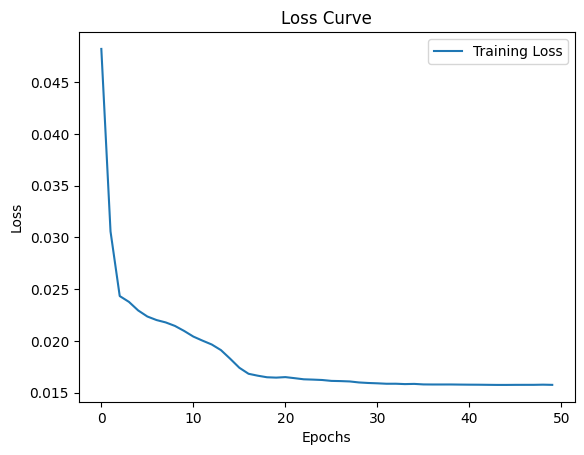

Latent space dataset saved as 'latent_space_diabetes_pytorch.csv'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler


# Load and preprocess the dataset
data = load_diabetes()
X = data.data

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Define the autoencoder structure
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Parameters
input_dim = X_tensor.shape[1]
encoding_dim = 2

# Model, loss, optimizer
model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Training the autoencoder
num_epochs = 50
batch_size = 16
losses = []

for epoch in range(num_epochs):
    for i in range(0, X_tensor.size(0), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        _, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract latent space representation
with torch.no_grad():
    latent_space, _ = model(X_tensor)

# Convert latent space to DataFrame
latent_space_np = latent_space.numpy()
latent_space_df = pd.DataFrame(latent_space_np, columns=[f'Latent_{i+1}' for i in range(encoding_dim)])

# Save latent space dataset
latent_space_df.to_csv('latent_space_diabetes_pytorch.csv', index=False)
print("Latent space dataset saved as 'latent_space_diabetes_pytorch.csv'.")
